In [3]:
# ============================================================
# COMPARATIVA FINAL DE MODELOS
# + variable más importante por modelo
# ============================================================

import os
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
)

# ------------------------------------------------------------
# 1. CARGA DATASET
# ------------------------------------------------------------
DATA_DIR = r"C:\Users\aitor.herran\Desktop\incendios"
DATASET_ML_PATH = os.path.join(DATA_DIR, "dataset_ml_prov_daily.csv")

df = pd.read_csv(DATASET_ML_PATH, parse_dates=["date"])
df["provincia"] = df["provincia"].astype(str).str.strip()

# ------------------------------------------------------------
# 2. TARGET Y FEATURES
# ------------------------------------------------------------
target = "y_riesgo_alto"

feature_cols = [
    c for c in df.columns
    if c.endswith("_lag1") or c.endswith("_roll3_mean")
]

X = df[feature_cols]
y = df[target]

# ------------------------------------------------------------
# 3. SPLIT TEMPORAL
# ------------------------------------------------------------
df["year"] = df["date"].dt.year
train_mask = df["year"] <= 2021
test_mask  = df["year"] > 2021

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# ------------------------------------------------------------
# 4. MODELOS A EVALUAR (MUCHOS)
# ------------------------------------------------------------
models = {
    "Random Forest (regularizado)": RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_leaf=50,
        max_features="sqrt",
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
    "Random Forest (base)": RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
    "Random Forest (profundo)": RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
    "Logistic Regression (balanced)": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
    "Logistic Regression (sin balanceo)": LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        random_state=42,
    ),
    "Extra Trees": ExtraTreesClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_leaf=50,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42,
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_depth=4,
        learning_rate=0.05,
        max_iter=300,
        random_state=42,
    ),
}

# ------------------------------------------------------------
# 5. FUNCIÓN DE EVALUACIÓN + THRESHOLD
# ------------------------------------------------------------
def evaluar_modelo(nombre, modelo):
    modelo.fit(X_train, y_train)

    # Probabilidades
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]
    else:
        y_proba = modelo.predict(X_test)

    # Threshold óptimo por F1
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)
    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]

    y_pred = (y_proba >= best_thr).astype(int)

    # Métricas
    roc_auc = roc_auc_score(y_test, y_proba)
    precision_1 = precision_score(y_test, y_pred, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, zero_division=0)
    f1_1 = f1_score(y_test, y_pred, zero_division=0)

    # Variable más importante
    if hasattr(modelo, "feature_importances_"):
        top_feature = feature_cols[
            np.argmax(modelo.feature_importances_)
        ]
    elif hasattr(modelo, "coef_"):
        top_feature = feature_cols[
            np.argmax(np.abs(modelo.coef_[0]))
        ]
    else:
        top_feature = "—"

    return {
        "variable_mas_importante": top_feature,
        "modelo": nombre,
        "threshold_opt": round(float(best_thr), 3),
        "roc_auc": round(roc_auc, 3),
        "precision_1": round(precision_1, 3),
        "recall_1": round(recall_1, 3),
        "f1_1": round(f1_1, 3),
    }

# ------------------------------------------------------------
# 6. EJECUCIÓN Y TABLA FINAL
# ------------------------------------------------------------
results = []

for name, model in models.items():
    print(f"Evaluando {name}...")
    results.append(evaluar_modelo(name, model))

# ------------------------------------------------------------
# TABLA FINAL LIMPIA: MEJOR → PEOR MODELO
# ------------------------------------------------------------
results_df = pd.DataFrame(results)

# Reordenar columnas (modelo primero)
results_df = results_df[
    [
        "modelo",
        "threshold_opt",
        "roc_auc",
        "precision_1",
        "recall_1",
        "f1_1",
    ]
]

# Ordenar de mejor a peor según F1
results_df = results_df.sort_values(
    by="f1_1",
    ascending=False
).reset_index(drop=True)

print("\n🏆 COMPARATIVA FINAL DE MODELOS (MEJOR → PEOR)")
display(results_df)

Evaluando Random Forest (regularizado)...
Evaluando Random Forest (base)...
Evaluando Random Forest (profundo)...
Evaluando Logistic Regression (balanced)...
Evaluando Logistic Regression (sin balanceo)...
Evaluando Extra Trees...
Evaluando HistGradientBoosting...

🏆 COMPARATIVA FINAL DE MODELOS (MEJOR → PEOR)


,modelo,threshold_opt,roc_auc,precision_1,recall_1,f1_1
0,HistGradientBoosting,0.152,0.779,0.380,0.540,0.446
1,Random Forest (regularizado),0.614,0.779,0.389,0.515,0.443
2,Logistic Regression (balanced),0.610,0.757,0.399,0.486,0.438
3,Random Forest (base),0.518,0.770,0.376,0.492,0.426
4,Random Forest (profundo),0.315,0.761,0.350,0.509,0.415
5,Logistic Regression (sin balanceo),0.162,0.723,0.458,0.360,0.403
6,Extra Trees,0.546,0.694,0.278,0.413,0.332


<Figure size 1200x600 with 0 Axes>

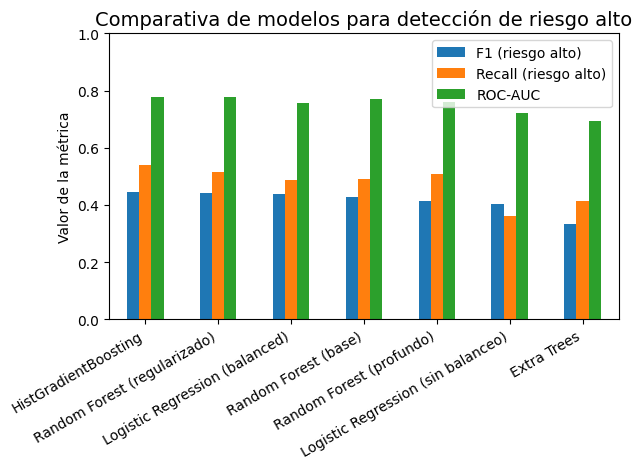

In [ ]:
# ============================================================
# GRÁFICA COMPARATIVA FINAL (TFM)
# ============================================================

import matplotlib.pyplot as plt

# Preparar datos
plot_df = results_df.set_index("modelo")[["f1_1", "recall_1", "roc_auc"]]

# Crear gráfica
plt.figure(figsize=(12, 6))
plot_df.plot(kind="bar")

plt.title("Comparativa de modelos para detección de riesgo alto", fontsize=14)
plt.ylabel("Valor de la métrica")
plt.xlabel("")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha="right")
plt.legend(
    ["F1 (riesgo alto)", "Recall (riesgo alto)", "ROC-AUC"],
    loc="upper right"
)

plt.tight_layout()
plt.show()

